(dl/07-attention)=
# Attention and Transformers

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/ok-transformer/blob/master/docs/nb/dl/07-attention.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/ok-transformer?style=social)](https://github.com/particle1331/ok-transformer)

---

**Readings:**  [[1]](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html), [[2]](https://www.d2l.ai/chapter_attention-mechanisms-and-transformers/index.html), [[3]](https://towardsdatascience.com/master-positional-encoding-part-i-63c05d90a0c3), {cite}`transformers`

## Introduction

Transformers directly take sequences of arbitrary length to make predictions. 
Its name comes from the fact that a Transformer model $\mathscr{T}$ takes in an input sequence $\boldsymbol{\mathsf{x}} \in \mathbb{R}^{T \times d}$ to an output sequence $\mathscr{T}(\boldsymbol{\mathsf{x}}) \in \mathbb{R}^{T \times d}$ of the sample shape. The output sequence can be thought of as a contextualized embedding that is better suited to the given task. Moreover, the sequence elements are processed in parallel.
The direct prediction approach can be contrasted to [recurrent networks](https://www.d2l.ai/chapter_recurrent-neural-networks/index.html) (RNNs) which iteratively takes each element of an input sequence, while updating a hidden state, thereby implicitly incorporating the network with positional information. Another alternative is to use a [temporal convolutional network](dl/04-lm/temporal-convolutions) (TCNs), but this becomes logarithmically deeper as $T$ grows, and has causal and local constraints.

This notebook implements the **Transformer architecture** originally proposed in {cite}`transformers`. First, we introduce the **attention mechanism** and provide examples to build intuition. Transformers are able to process sequences of arbitrarily length by using the attention mechanism that allow each sequence element to communicate with any other element directly (e.g. without passing through multiple layers as in RNNs, or without locality constraints as in TCNs) and determine whether this token is relevant given the current token. 

The **multi-head attention layer** (MHA) adds further complexity to the attention operation which we cover next. The situation is similar to convolutions and the multi-channel convolutional layer. Note that MHA treats a sequence as a set, i.e. it discards positional information.
This makes it applicable to a wide range of tasks. 
Relative and absolute positional information can be injected back into the model by using **positional encoding** or **positional embeddings** which we cover next. 

Finally, we implement the **Transformer encoder**. The encoder block adds normalization layers and a fully-connected subnetwork that adds more complexity to the model. To demonstrate training a Transformer based model, we train a Seq2seq model for reverse sequence prediction by attaching a fully-connected classification head $F$ applied to the encoded embeddings. Our model performs the following mapping where $C$ is the number of possible characters:

$$
\mathbb{R}^{T \times d} \overset{\mathscr{T}}{\mapsto} \mathbb{R}^{T \times d} \overset{F}{\mapsto} [0, 1]^{T \times C}
$$

<br>

In [1]:
import math
import torch
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from matplotlib_inline import backend_inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
DATASET_DIR = Path("./data").absolute()
RANDOM_SEED = 42
DEBUG = False
MATPLOTLIB_FORMAT = "png" if DEBUG else "svg"

!rm -rf "./logs/ReversePrediction"
pl.seed_everything(RANDOM_SEED)
warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats(MATPLOTLIB_FORMAT)
print("device:", DEVICE)

Seed set to 42


device: mps


## Attention mechanism

An **attention mechanism** involves averaging state or **value** vectors of input elements dynamically based on a soft lookup with respect to the corresponding **keys** of each element given an input **query**. The values are combined using a convex combination $\sum_{j} a_j \boldsymbol{\mathsf{v}}_j$ as output of the layer where $\sum_ja_j = 1.$ The weights $a_j$ are typically obtained using the softmax:

$$
a_j=\frac{\exp \left(f_{\text {attn}}\left(\boldsymbol{\mathsf{q}}, \boldsymbol{\mathsf{k}}_j\right)\right)}{\sum_k \exp \left(f_{\text {attn}}\left(\boldsymbol{\mathsf{q}}, \boldsymbol{\mathsf{k}}_k\right)\right)}, \quad \text {out}=\sum_j a_j \boldsymbol{\mathsf{v}}_j
$$

where $f_{\text {attn }}$ is called the **score function**. The vectors $\boldsymbol{\mathsf{k}}_i, \boldsymbol{\mathsf{v}}_i$ for $i = 1, \ldots, T$ are obtained from a sequence of inputs $(\boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_T)$ and the query vector $\boldsymbol{\mathsf{q}}$ from a test input $\boldsymbol{\mathsf{y}}.$ The functions for transforming inputs to keys, queries, and values are generally parametric and are learned during the course of training. This scoring part sort of implements [kernel similarity](https://en.wikipedia.org/wiki/Kernel_method) where we score the similarity of vectors in the representation space (see [this answer](https://stats.stackexchange.com/a/463320/313872) in SE).

<br>

```{figure} ../../img/nn/07-qkv.svg
---
name: 07-qkv
width: 400px
---
Soft lookup by pooling value vectors using attention weights. [Source](https://www.d2l.ai/chapter_attention-mechanisms-and-transformers/queries-keys-values.html)
```

**Q and K.** The query is a feature vector which can be interpreted as what the input is "looking for". 
The keys are learned to maximize $f_{\text {attn }}$ with an appropriate query.
It roughly describes what an input $\boldsymbol{\mathsf{x}}_i$ is "offering", or when it might be important. The score function $f_{\text {attn }}$ which evaluates the key-query pair is usually implemented by simple similarity metrics like a dot product or a small MLP. Note that the roles of queries and keys are inherently asymmetric, hence since the scoring function is usually defined as a symmetric operation, the transformations from input to query and key vectors are defined separately. 

**Values.** The value vectors are task-specific and designed for downstream processing. 
The resulting weighted average reflects what the query vector is paying attention to in the sequence.
For example, in language modeling, the value vectors can be thought of as modified embeddings 
which help with resolving ambiguity in the original embeddings by combining the context (with convex weights) given a query.

**Attention as soft lookup.** Observe that the attention mechanism is similar to a kernel KNN. But instead of returning the label of the most similar training vector, it outputs a weighted label based on its similarity scores. In other words, instead of a hard lookup in $\{(\boldsymbol{\mathsf{k}}_1, \boldsymbol{\mathsf{v}}_1), \ldots, (\boldsymbol{\mathsf{k}}_T, \boldsymbol{\mathsf{v}}_T)\}$, a test data performs a **soft lookup** operation with the keys. This can be seen in the following example:

In [2]:
def kernel_fn(d, sigma):
    return torch.exp(-d ** 2 / (2 * sigma ** 2))

def kernel(q, k, sigma):
    d = q.view(-1, 1) - k.view(1, -1)    # d_ij = q_i - k_j
    return kernel_fn(d, sigma)           # exp(-(q_i - k_j)² / 2σ²)

def f(x):
    return 2 * torch.sin(x) + x

# Toy dataset
n = 120
x_train, _ = torch.sort(torch.rand(n) * 10)
y_train = f(x_train) + torch.randn(n)   # signal + noise
x = torch.arange(0, 10, 0.1)
y = f(x)

Here the values are scalars and the keys and queries are identical for each instance:

In [3]:
def attention_pooling(x_train, y_train, x, sigma=1.0):
    """Nadaraya-Watson regression (1964)."""
    k = kernel(x, x_train, sigma=sigma)
    attn_weights = k / k.sum(0)     # linear: kernel already has exps
    y_hat = attn_weights @ y_train
    return y_hat, attn_weights

Plotting the values and attention weights (kernel scores):

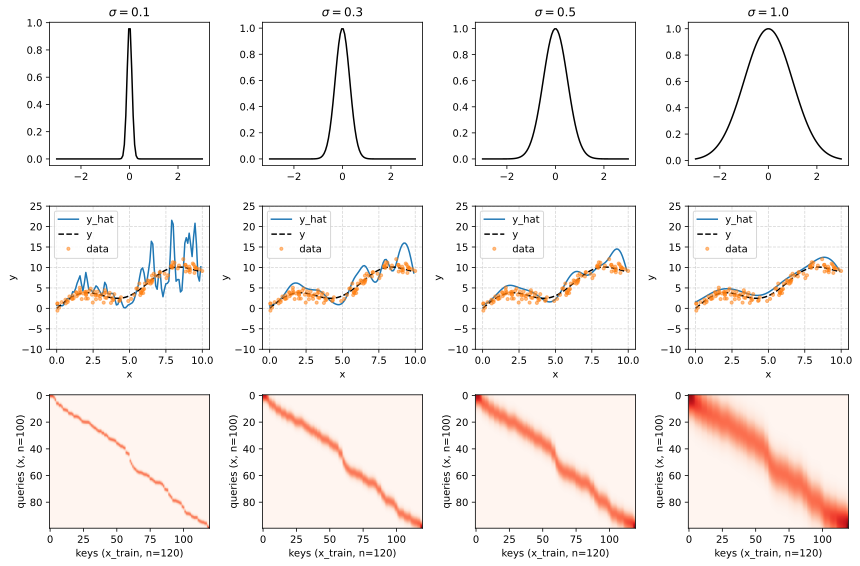

In [4]:
fig, ax = plt.subplots(3, 4, figsize=(12, 8))

for i, sigma in enumerate([0.1, 0.3, 0.5, 1.0]):
    y_hat, attn_weights = attention_pooling(x_train, y_train, x, sigma=sigma)
    t = torch.linspace(-3, 3, 100)
    ax[0, i].plot(t, kernel_fn(t, sigma), color="k")
    ax[0, i].set_title(r"$\sigma =$" + f"{sigma:.1f}")
    ax[1, i].plot(x, y_hat, label="y_hat")
    ax[1, i].plot(x, y, 'k--', label="y")
    ax[1, i].plot(x_train, y_train, 'o', markersize=3.1, alpha=0.5, label="data")
    ax[1, i].set_xlabel("x")
    ax[1, i].set_ylabel("y")
    ax[1, i].set_ylim(-10, 25)
    ax[1, i].legend()
    ax[1, i].grid(linestyle="dashed", alpha=0.5)
    ax[2, i].imshow(attn_weights.detach().numpy(), cmap='Reds')
    ax[2, i].set_ylabel(f"queries (x, n={len(x)})")
    ax[2, i].set_xlabel(f"keys (x_train, n={len(x_train)})");

fig.tight_layout()

**Figure.** Gaussian kernel width is controlled by the $\sigma$ parameter. The narrower the kernel, the less smooth the estimate becomes. At the same time, it adapts better to local variations. In the context of attention, the width of the kernel essentially increases or decreases the points in the dataset that a test query "attends" to as shown in the attention weights plot.

## Scaled dot product attention

Attention mechanisms differ in terms of what queries they use, how the key and value vectors are defined, and what score function is used. In this section,
we describe the **scaled dot product attention** (SDPA). The goal of this attention mechanism is that any element in a sequence can attend to unmasked elements of the other sequence while still being efficient to compute:

$$
\operatorname{Attention}(\boldsymbol{\mathsf{Q}}, \boldsymbol{\mathsf{K}}, \boldsymbol{\mathsf{V}})
=\operatorname{Softmax}\left(\frac{\boldsymbol{\mathsf{Q}} \boldsymbol{\mathsf{K}^\top}}{\sqrt{d}} + \boldsymbol{\mathsf{M}}\right) \boldsymbol{\mathsf{V}}.
$$

Here $\boldsymbol{\mathsf{Q}}$ and $\boldsymbol{\mathsf{K}}$ are 
$T_q \times d$ and $T_k \times d$ matrices, respectively,
with rows consisting of query vectors $(\boldsymbol{\mathsf{q}}_1, \ldots, \boldsymbol{\mathsf{q}}_{T_q})$ and key vectors $(\boldsymbol{\mathsf{k}}_1, \ldots, \boldsymbol{\mathsf{k}}_{T_k}).$ The value matrix $\boldsymbol{\mathsf{V}}$ is $T_k \times d_v$ and contains rows of value vectors $(\boldsymbol{\mathsf{v}}_1, \ldots, \boldsymbol{\mathsf{v}}_{T_k})$ corresponding to the keys.
The matrix
$\boldsymbol{\mathsf{M}}$, called the **attention mask**, is $T_q \times T_k$ with entries either $0$ or $-\infty$. The factor $\sqrt{d}$ is there so that variance ~ 1. 
The final output is then $T_q \times d_v$  which corresponds to one value vector per query. 
Note that the batch dimension is supressed for simplicity. Observe that computation is efficient regardless of context sizes $T_q$ and $T_k$ since it involves only matrix operations. 

**Masking.** Note that the attention weights has shape $T_q \times T_k$ which corresponds to communication between any two query-key pair. 
Since $\exp(-\infty) = 0$, this means that the weights are computed over the unmasked attention scores. 
Hence, an attention mask nullifies any communication between two pairs of inputs. For example, in **causal attention**, $\boldsymbol{\mathsf{M}}_{ij} = -\infty$ precisely when $j > i$ so that a query cannot look at future keys in the sequence.
In our implementation, we use indicators to mask attention scores instead of adding a tensor `M`:

In [5]:
T = 3
mask = torch.tril(torch.ones(T, T))  # causal
attn_score = torch.randn(3, 3)
print("Mask (indicators)\n", mask, "\n")
print("Attention scores\n", attn_score, "\n")
print("Masked attention scores\n", attn_score.masked_fill(mask == 0, -torch.inf))

Mask (indicators)
 tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]]) 

Attention scores
 tensor([[ 0.0110,  0.1447,  1.2818],
        [-1.5952, -1.0648,  0.1055],
        [ 1.9739,  1.0703, -1.7379]]) 

Masked attention scores
 tensor([[ 0.0110,    -inf,    -inf],
        [-1.5952, -1.0648,    -inf],
        [ 1.9739,  1.0703, -1.7379]])


In [6]:
pl.seed_everything(RANDOM_SEED)

Seed set to 42


42

PyTorch implementation of SDPA:

In [7]:
def scaled_dot_product(q, k, v, mask=None):
    d = q.shape[-1]
    attn_score = torch.einsum("ik, jk -> ij", q, k)
    attn_score = attn_score / math.sqrt(d)
    if mask is not None:
        assert mask.shape == attn_score.shape
        attn_score = attn_score.masked_fill(mask == 0, -torch.inf)
    
    attention = F.softmax(attn_score, dim=-1)
    values = torch.einsum("ik, kj -> ij", attention, v)
    return values, attention

Example computation of causal attention:

In [8]:
T, d, v = 3, 2, 4
q = torch.randn(T, d)
k = torch.randn(T, d)
v = torch.randn(T, v)
output, attention = scaled_dot_product(q, k, v, mask)

print("Q\n", q, "\n")
print("K\n", k, "\n")
print("V\n", v, "\n")
print("Attention\n", attention, "\n")
print("Output\n", output, "\n")

Q
 tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863]]) 

K
 tensor([[ 2.2082, -0.6380],
        [ 0.4617,  0.2674],
        [ 0.5349,  0.8094]]) 

V
 tensor([[ 1.1103, -1.6898, -0.9890,  0.9580],
        [ 1.3221,  0.8172, -0.7658, -0.7506],
        [ 1.3525,  0.6863, -0.3278,  0.7950]]) 

Attention
 tensor([[1.0000, 0.0000, 0.0000],
        [0.5355, 0.4645, 0.0000],
        [0.1303, 0.4630, 0.4067]]) 

Output
 tensor([[ 1.1103, -1.6898, -0.9890,  0.9580],
        [ 1.2087, -0.5252, -0.8853,  0.1643],
        [ 1.3069,  0.4372, -0.6168,  0.1007]]) 



The output vectors are obtained as convex combination of attention weights and value vectors:

In [9]:
0.1303 * v[0] + 0.4630 * v[1] + 0.4067 * v[2]

tensor([ 1.3069,  0.4373, -0.6167,  0.1006])

The first vector only attends to itself, so the value vector is unchanged.

<br>

**Remark.** PyTorch has an [efficient implementation](https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html) of SDPA similar to what we have above:

In [10]:
# WARNING: Expects boolean mask! if float, additive implementation, i.e. +M
F.scaled_dot_product_attention(q, k, v, mask.bool())

tensor([[ 1.1103, -1.6898, -0.9890,  0.9580],
        [ 1.2087, -0.5252, -0.8853,  0.1643],
        [ 1.3069,  0.4372, -0.6168,  0.1007]])

This is so much faster and more stable compared to our implementation:

In [11]:
%%timeit -n 1000
# einsum is slow (see https://github.com/pytorch/pytorch/issues/32591)
# but F.scaled_dot_product_attention still beats permute and @ by 20% relative
scaled_dot_product(q, k, v, mask)

50.7 µs ± 5.33 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [12]:
%%timeit -n 1000
F.scaled_dot_product_attention(q, k, v, mask.bool())

15.4 µs ± 405 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Multi-head attention (MHA)

Given the same set of queries, keys, and values we may want our model to combine knowledge from different behaviors of the same attention mechanism, such as capturing dependencies of various ranges (shorter range vs. longer range, or different word senses). 
Hence, we extend the attention mechanism to have **multiple heads**, i.e. $(\boldsymbol{\mathsf{Q}}_i, \boldsymbol{\mathsf{K}}_i, \boldsymbol{\mathsf{V}}_i)$ triples for $i = 1, \ldots, H$, on the same inputs. 
This is similar to convolutions where we learn multiple feature detectors in parallel. We will assume $d = d_v = d_\text{model}.$ Let $\boldsymbol{\mathsf{Q}} \in \mathbb{R}^{T_q \times d_\text{model}}$ and $\boldsymbol{\mathsf{K}}, \boldsymbol{\mathsf{V}} \in \mathbb{R}^{T_k \times d_{\text{model}}}$, then:

$$\begin{aligned}
\operatorname{MultiheadAttention}(\boldsymbol{\mathsf{Q}}, \boldsymbol{\mathsf{K}}, \boldsymbol{\mathsf{V}})
&= \bigoplus_{i=1}^H\left[\text{Attention}(\boldsymbol{\mathsf{Q}} \boldsymbol{\mathsf{W}}_i^\mathsf{Q}, \boldsymbol{\mathsf{K}} \boldsymbol{\mathsf{W}}_i^\mathsf{K}, \boldsymbol{\mathsf{V}} \boldsymbol{\mathsf{W}}_i^\mathsf{V})\right]\, {\boldsymbol{\mathsf{W}}^{\mathsf{O}}} \\
&\in \mathbb{R}^{T_q \times d_\text{model}}
\end{aligned}$$

where $\boldsymbol{\mathsf{W}}^\mathsf{O} \in \mathbb{R}^{d_{\text{model}} \times d_{\text{model}}}.$ Note that the number of heads $H$ must divide $d_\text{model}.$ The biases are usually not included as we do here. The idea is that $\boldsymbol{\mathsf{W}}_i^\mathsf{Q} \in \mathbb{R}^{d_{\text{model}} \times d_h}$ projects the queries $\boldsymbol{\mathsf{Q}}$ onto a lower dimensional subspace of dimension $d_h = d_{\text{model}} / H$, and similarly for keys and values. 
Finally, the lower dimensional output heads $\boldsymbol{\mathsf{h}}_i$ are mixed together at the end as 
$\boldsymbol{\mathsf{o}}^j = \sum_{i=1}^H \boldsymbol{\mathsf{h}}_i \cdot \boldsymbol{\mathsf{w}}_i^j$
for $j = 1, \ldots, d_\text{model}$
where $\bigoplus_{i=1}^H \boldsymbol{\mathsf{w}}_i^j$ is the $j$-th row of $\boldsymbol{\mathsf{W}}^\mathsf{O}.$
Multi-head attention therefore combines knowledge of the same attention pooling via different representation subspaces of queries, keys, and values. The architecture is depicted in {numref}`07-mha`.

**Remark.** To facilitate residuals, all sub-layers in the model, including the embedding
layers, produce outputs of dimension $d_\text{model}$ following {cite}`transformers`. Also, note that the queries $\boldsymbol{\mathsf{Q}}$ are projected to $\boldsymbol{\mathsf{Q}}_i = \boldsymbol{\mathsf{Q}}\boldsymbol{\mathsf{W}}_i^\mathsf{Q}.$ Hence, it suffices to learn a single fused matrix $\boldsymbol{\mathsf{W}}^\mathsf{Q}$ where we calculate $\boldsymbol{\mathsf{Q}}_i$ as an $h$-sized slice of $\hat{\boldsymbol{\mathsf{Q}}} = \boldsymbol{\mathsf{Q}}\boldsymbol{\mathsf{W}}^\mathsf{Q}.$ Similarly we learn weights to calculate $\hat{\boldsymbol{\mathsf{K}}} = \boldsymbol{\mathsf{K}}\boldsymbol{\mathsf{W}}^\mathsf{K}$ and $\hat{\boldsymbol{\mathsf{V}}} = \boldsymbol{\mathsf{V}}\boldsymbol{\mathsf{W}}^\mathsf{V}$ for the keys and queries. This is what we will do in the implementation below, where we calculate MHA in parallel in a single pass after carefully indexing the $\hat{\boldsymbol{\mathsf{Q}}}, \hat{\boldsymbol{\mathsf{K}}}, \hat{\boldsymbol{\mathsf{V}}}$ tensors.

<br>

```{figure} ../../img/nn/07-mha.png
---
name: 07-mha
width: 250px
---
Multi-head attention. Source: {cite}`transformers`
```

**Self-attention.** Let $\boldsymbol{\mathsf{X}} = (\boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_{T}).$ The important case where $\boldsymbol{\mathsf{Q}}, \boldsymbol{\mathsf{K}}, \boldsymbol{\mathsf{V}} = \boldsymbol{\mathsf{X}}$ is called **self-attention**. Here any sequence element attends to itself. The attention score has shape $T \times T$ since $T = T_q = T_k.$ This can be masked depending on the implementation, e.g. to prevent data leakage. 
For example, in **causal self-attention**, the mask has $\boldsymbol{\mathsf{M}}_{ij} = -\infty$ precisely when $j > i$ so that a query cannot look at future keys in the same sequence.
Finally, the computation is asymmetric, the score $\boldsymbol{\mathsf{q}} \cdot \boldsymbol{\mathsf{k}}$ for the same input vector $\boldsymbol{\mathsf{x}}$ need not be 1 (i.e. $\boldsymbol{\mathsf{x}}$ is not looking for itself) since the embedding vectors $\boldsymbol{\mathsf{X}}$ are projected using different transformations.

<br>

In [13]:
class MultiheadAttention(nn.Module):
    
    def __init__(self, d_model: int, num_heads: int, dropout=0.0):
        super().__init__()
        assert d_model % num_heads == 0, "No. of heads divides d_model."
        self.d_model = d_model
        self.n_heads = num_heads
        self.d_head = d_model // num_heads
        self.dropout_p = dropout

        # Stack all weight matrices 1...H together for efficiency
        self.w_q = nn.Linear(d_model, d_model, bias=False)
        self.w_k = nn.Linear(d_model, d_model, bias=False)
        self.w_v = nn.Linear(d_model, d_model, bias=False)
        self.w_o = nn.Linear(d_model, d_model, bias=False)

    def forward(self, query, key, value, mask=None, return_attention=False):
        """
        Queries, keys, and values are expected to have shapes (B, T, d_model).
        Two types of masks are supported. A boolean mask where a value of True 
        indicates that the element should take part in attention. A float mask 
        of same type as query, key, value that is added to the attention score.
        """
        if mask is not None:
            mask = self.expand_mask(mask)

        # Project onto subspaces
        q = self.w_q(query)     # (B, Tq, d_model) -> (B, Tq, d_model)
        k = self.w_k(key)       # (B, Tk, d_model) -> (B, Tk, d_model)
        v = self.w_v(value)     # (B, Tk, d_model) -> (B, Tk, d_model)

        # Decompose: (B, T, d_model) -> (B, T, H, d_head) -> (B, H, T, d_head)
        B  = q.shape[0]
        Tq = q.shape[1]
        Tk = k.shape[1]
        q = q.view(B, Tq, self.n_heads, self.d_head).transpose(1, 2)
        k = k.view(B, Tk, self.n_heads, self.d_head).transpose(1, 2)
        v = v.view(B, Tk, self.n_heads, self.d_head).transpose(1, 2)
        
        # Calculate attention on the subspaces
        dropout_p = 0.0 if not self.training else self.dropout_p
        head = F.scaled_dot_product_attention(q, k, v, mask, dropout_p=dropout_p)
        
        # Concat heads and transform to final output
        head = head.permute(0, 2, 1, 3)            # (B, H, Tq, d_head) -> (B, Tq, H, d_head)
        head = head.reshape(B, Tq, self.d_model)   # (B, Tq, H, d_head) -> (B, Tq, d_model)
        o = self.w_o(head)
        
        if return_attention:
            attn_weight = self.attention_weight(q, k, mask)
            return o, attn_weight
        else:
            return o
    
    @staticmethod
    def attention_weight(q, k, mask=None):
        v = torch.eye(k.shape[-2]).to(k.device)  # extract weights
        attn_weight = F.scaled_dot_product_attention(q, k, v, mask)
        return attn_weight

    @staticmethod
    def expand_mask(mask):
        """
        Helper function to support different mask shapes.
        Return shape: (B, H, Tq, Tk). If
            2D: broadcasted over batch and heads dim
            3D: broadcasted over heads dim
            4D: leave as is
        """
        cases = {   # lazy
            2: lambda m: m.unsqueeze(0).unsqueeze(0),
            3: lambda m: m.unsqueeze(1),
            4: lambda m: m
        }
        try:
            return cases[mask.ndim](mask)
        except KeyError:
            raise ValueError("Mask must be at least 2-dimensional with shape (Tq, Tk)")

Checking the expected shapes:

In [14]:
mha = MultiheadAttention(d_model=512, num_heads=8)

x = torch.randn(32, 10, 512)    # Tk = 10
y = torch.randn(32, 20, 512)    # Tq = 20
mask = torch.tril(torch.ones(20, 10)).bool()

# set Q = Y and K, V = X
out, attn = mha(query=y, key=x, value=x, mask=mask, return_attention=True)
out.shape, attn.shape   # expected: (B, Tq, d_model) & (B, H, Tq, Tk)

(torch.Size([32, 20, 512]), torch.Size([32, 8, 20, 10]))

Checking code correctness:

In [15]:
# validating the code inside MHA
q = mha.w_q(y).view(32, 20, 8, 64).transpose(1, 2)
k = mha.w_k(x).view(32, 10, 8, 64).transpose(1, 2)
v = mha.w_v(x).view(32, 10, 8, 64).transpose(1, 2)
head = F.scaled_dot_product_attention(q, k, v, mask)

# batch idx = 0, head idx = 0
attn_score = q[0][0] @ k[0][0].transpose(-2, -1) / 8
attn_score = attn_score.masked_fill(mask == 0, -torch.inf)
print(torch.abs(head[0][0] - F.softmax(attn_score, dim=-1) @ v[0][0]).max())

# entire output from scratch
attn_score = q @ k.transpose(-2, -1) / 8
attn_score = attn_score.masked_fill(mask == 0, -torch.inf)
w = F.softmax(attn_score, dim=-1)
o = mha.w_o((w @ v).permute(0, 2, 1, 3).reshape(32, 20, 512))
print(torch.abs(o - out).max())
print(torch.abs(w - attn).max())

tensor(8.9407e-08, grad_fn=<MaxBackward1>)
tensor(2.6822e-07, grad_fn=<MaxBackward1>)
tensor(8.9407e-08, grad_fn=<MaxBackward1>)


<br>

**Attention dropout.** To avoid overfitting, we want to add regularization in the attention layer. Here we add dropout on the attention weights (see [docs](https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html) and {cite}`drop-attention`). Dropping the attention weight $a_{ij}$ effectively zeros out the communication of a query $\boldsymbol{\mathsf{q}}_i$ with a key $\boldsymbol{\mathsf{k}}_j$, so that the corresponding vector $\boldsymbol{\mathsf{v}}_j$ is excluded from the weighted sum.
The idea is to prevent different contextualized feature vectors from co-adaption. An issue with the PyTorch implementation is that the attention weights are not re-normalized (they are rescaled by `1 / (1 - dropout_p)`). But on average, the remaining weights still sum to 1:

mean total weight (train): 1.00119
mean total weight (valid): 1.00000


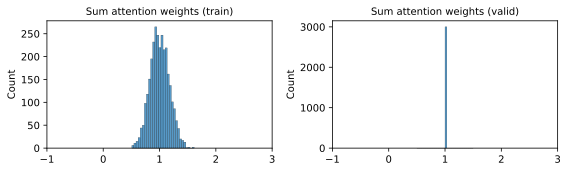

In [16]:
import seaborn as sns

q = torch.randn(10, 16)
k = torch.randn(10, 16)
v = torch.eye(10)    # set v = id, to get the attn weights

s, t = [], []
for _ in range(3000):
    a = F.scaled_dot_product_attention(q, k, v, dropout_p=0.6)
    b = F.scaled_dot_product_attention(q, k, v, dropout_p=0.0)
    s.append(a.sum(dim=1).mean().item())
    t.append(b.sum(dim=1).mean().item())

fig, ax = plt.subplots(1, 2, figsize=(8, 2.5))
ax[0].set_xlim(-1, 3)
ax[1].set_xlim(-1, 3)
ax[0].set_title("Sum attention weights (train)", size=10)
ax[1].set_title("Sum attention weights (valid)", size=10)
sns.histplot(s, ax=ax[0], bins=30)
sns.histplot(t, ax=ax[1], bins=30)
fig.tight_layout()
print(f"mean total weight (train): {sum(s) / len(s):.5f}")
print(f"mean total weight (valid): {sum(t) / len(t):.5f}")

MHA output norms for same inputs with dropout:

mean train norm: -0.14006
mean valid norm: -0.13852


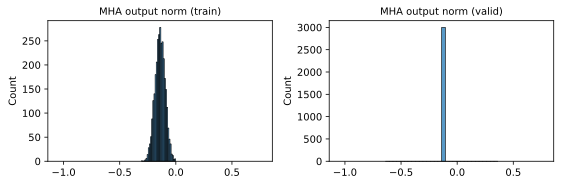

In [17]:
mha = MultiheadAttention(16, num_heads=1, dropout=0.5)

q = torch.randn(1, 10, 16)
k = torch.randn(1, 10, 16)
v = torch.randn(1, 10, 16)

s, t = [], []
for _ in range(3000):
    a = mha(q, k, v)
    mha.eval()
    b = mha(q, k, v)
    mha.train()
    s.append(a.sum(dim=1).mean().item())
    t.append(b.sum(dim=1).mean().item())

fig, ax = plt.subplots(1, 2, figsize=(8, 2.5))
sns.histplot(s, ax=ax[0], bins=30)
sns.histplot(t, ax=ax[1], bins=30)
fig.tight_layout()
train_norm = sum(s) / len(s)
valid_norm = sum(t) / len(t)
print(f"mean train norm: {train_norm:.5f}")
print(f"mean valid norm: {valid_norm:.5f}")
ax[0].set_xlim(-1 + train_norm, 1 + train_norm)
ax[1].set_xlim(-1 + train_norm, 1 + train_norm)
ax[0].set_title("MHA output norm (train)", size=10)
ax[1].set_title("MHA output norm (valid)", size=10);

## Positional encoding

Note that the MHA is permutation-invariant with respect to the source sequences $\boldsymbol{\mathsf{K}}$ and $\boldsymbol{\mathsf{V}}$ and permutation-equivariant to the target sequence $\boldsymbol{\mathsf{Q}}.$
This is demonstrated in the following code cell. Hence, MHA is looking at the input not as a sequence, but as a set of elements. This property of MHA (and by extension, the Transformer architecture) makes it powerful and widely applicable to various data modalities and tasks. But what if the order of the input is actually important for solving the task, like language modeling? One solution is to encode the position information along with the input features.

In [18]:
x = torch.randn(1, 4, 512)    # Tk = 1
y = torch.randn(1, 2, 512)    # Tq = 2
mask = torch.tril(torch.ones(2, 4)).bool()
mha = MultiheadAttention(d_model=512, num_heads=8)
out = mha(query=y, key=x, value=x)

# reordering the sequences:
y_idx = torch.tensor([1, 0]).long()
x_idx = torch.tensor([1, 0, 2, 3]).long()
y_ = y[:, y_idx, :]
x_ = x[:, x_idx, :]
out_ = mha(query=y_, key=x_, value=x_)  # mask[y_idx][:, x_idx]
print(torch.abs(out_ - out[:, y_idx, :]).max())

tensor(8.9407e-08, grad_fn=<MaxBackward1>)


This can be done by learning an embedding tensor $\boldsymbol{\mathsf{P}}$ of shape $T \times d_{\text{model}}$ assuming fixed context size $T.$ This are then added to the input embeddings $\boldsymbol{\mathsf{X}} \leftarrow \boldsymbol{\mathsf{X}} + \boldsymbol{\mathsf{P}}$ before passing to the attention blocks. See [this](https://github.com/karpathy/nanoGPT/blob/master/model.py#L128) and [this](https://github.com/karpathy/nanoGPT/blob/master/model.py#L177-L179) from https://github.com/karpathy/nanoGPT. The idea is to shift the original embeddings towards regions in the space determined by the direction $\boldsymbol{\mathsf{p}}_t$ for $t = 1, \ldots, T.$

**Absolute position.** An alternative approach is to use data-independent static patterns that the network can hopefully identify from the features. The specific pattern chosen in the original paper {cite}`transformers` are
sine and cosine functions of different frequencies, as follows:

$$
\begin{aligned}
\boldsymbol{\mathsf{P}}_{t, 2j} &= \sin\left({t} \cdot {\omega^{\frac{2j}{d_\text{model}}}} \right) \\
\boldsymbol{\mathsf{P}}_{t, 2j + 1} &= \cos\left({t} \cdot {\omega^{\frac{2j}{d_\text{model}}}} \right)
\end{aligned}
$$

for $t = 1, \ldots, T$ and $\omega = 1/10,000$ is [a hyperparameter](https://datascience.stackexchange.com/a/112423/155484). The position encoding vectors are added to the input embeddings $\boldsymbol{\mathsf{X}} \leftarrow \boldsymbol{\mathsf{X}} + \boldsymbol{\mathsf{P}}$ before passing to the attention blocks. Using sinusoidal function works because they are bounded
so information from the original embedding is not erased. 
Moreover, the values are independent of the inputs, e.g. we use the same positional embedding vector for the first vector in a sequence regardless of the input vector. 

But what does this tell us about the position? 
The pattern in the embedding dimension encodes the position index. Consider the following binary representation of each position index. 
The bits are periodic, where a higher bit has a lower frequency than a lower bit.
Instead of using bits, we use $d_\text{model}$ periodic floats. 
For dimension $j = 0,$ the wavelength of the waves are $2\pi$ and $10,000 \cdot 2\pi$ for $2j = d_\text{model}.$ From [Euler's formula](https://en.wikipedia.org/wiki/Euler%27s_formula), the values in an embedding dimension are coordinates of a circle with frequency $\omega^{\frac{2j}{d_\text{model}}}.$

In [19]:
for i in range(8):
    print(f"{i} in binary is {i:>03b}")

0 in binary is 000
1 in binary is 001
2 in binary is 010
3 in binary is 011
4 in binary is 100
5 in binary is 101
6 in binary is 110
7 in binary is 111


Position encoding (and its uniqueness) can be visualized as follows:

In [20]:
T = 300
d_model = 256
pe = torch.zeros(T, d_model)
t = torch.arange(0, T, dtype=torch.float).unsqueeze(1)
w = torch.exp(-(torch.arange(0, d_model, 2).float() / d_model * math.log(10000)))   # exp-log
pe[:, 0::2] = torch.sin(t * w)
pe[:, 1::2] = torch.cos(t * w)

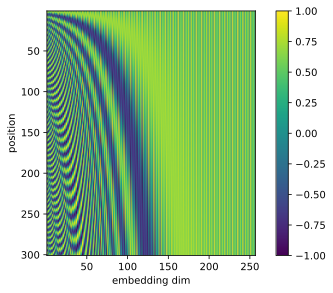

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
pos = ax.imshow(pe.numpy(), extent=(1, pe.shape[1] + 1, pe.shape[0] + 1, 1))
fig.colorbar(pos, ax=ax)
fig.tight_layout()
ax.set_xlabel("embedding dim")
ax.set_ylabel("position");

Observe that vertical lines at greater depth vary less than those at lower depth. This is because the frequency of the sine waves decrease with higher embedding depth. Hence, most of the positional embedding matrix is uninformative, i.e. later embedding dimensions is roughly constant (0 or 1) with respect to position. The logarithm-like curve is nice since this means the PE matrix tries as much as possible not to corrupt the original embedding weights. The individual PE vectors are visualized as follows:

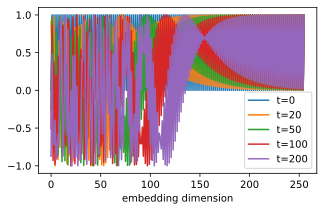

In [22]:
plt.figure(figsize=(5, 3))
for t in [0, 20, 50, 100, 200]:
    plt.plot(pe[t], label=f"t={t}")
plt.legend()
plt.xlabel("embedding dimension");

<br>

**Relative position.** Besides capturing absolute positional information, the above positional encoding also allows a model to easily learn to attend by relative positions. This is because for any fixed position offset $\Delta t$, the positional encoding $\boldsymbol{\mathsf{p}}_{t + \Delta t}$ at position $t + \Delta t$ can be represented as a linear projection of the position encoding $\boldsymbol{\mathsf{p}}_{t}$ at position $t.$ To see this, let $\omega_j = \omega^{{2j}/{d_\text{model}}}$ and recall the rotation transformation:

$$\begin{aligned}
\begin{bmatrix} \phantom{-} \cos(\Delta t \cdot \omega_j) & \sin(\Delta t \cdot \omega_j) \\  -\sin(\Delta t \cdot \omega_j) & \cos(\Delta t \cdot \omega_j) \\ \end{bmatrix}
\begin{bmatrix} \mathsf{p}_{t, 2j} \\  \mathsf{p}_{t, 2j+1} \\ \end{bmatrix}
=&\begin{bmatrix} \phantom{-} \cos(\Delta t \cdot \omega_j) \, \sin(t \cdot \omega_j) + \sin(\Delta t \cdot \omega_j) \, \cos(t \cdot \omega_j) \\  -\sin(\Delta t \cdot \omega_j) \, \sin(t \cdot \omega_j) + \cos(\Delta t \cdot \omega_j) \, \cos(t \cdot \omega_j) \\ \end{bmatrix}\\
=&\begin{bmatrix} \sin\left((t+\Delta t) \cdot \omega_j\right) \\  \cos\left((t+\Delta t) \cdot \omega_j\right) \\ \end{bmatrix}\\
=& 
\begin{bmatrix} \mathsf{p}_{i+\Delta t, 2j} \\  \mathsf{p}_{i+\Delta t, 2j+1} \\ \end{bmatrix}
\end{aligned}$$

where the $2\times 2$ projection matrix does not depend on any position index $t$. 
Note that we can build a full linear transformation of $\boldsymbol{\mathsf{P}}$ by using a block-diagonal matrix consisting of the above $2\times 2$ matrices. Since the MHA involves linear transformation of the input sequence, this might allow the model to easily attend to relative positions.

<br>

**Effect on attention.** Let us not look at how positional encodings are used in an actual attention model. One property we might want to have our position embeddings is that positions close to each other return large attention weights, while those far away return small ones. Of course, this is augmented by the actual keys and queries of the sequence vectors. But for raw PE vectors, this seems to be a good property to generally have.

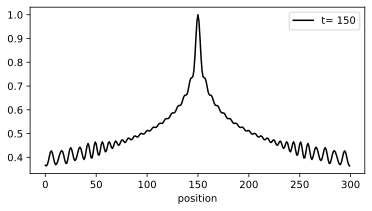

In [23]:
# normalized dot product with other PE vectors.
attn_score = (pe @ pe.T)[T // 2]
attn_score = attn_score / attn_score.max()
plt.figure(figsize=(6, 3))
plt.plot(attn_score, "k", label=f"t= {T // 2}")
plt.xlabel("position")
plt.legend();

This has to do with the [orthogonality](https://tutorial.math.lamar.edu/classes/de/PeriodicOrthogonal.aspx) of sine and cosine functions.

<br>

**Implementation.** Implementing the positional encoding module:

In [24]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        t = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)                        # (max_len, 1)
        w = torch.exp(-(torch.arange(0, d_model, 2).float() / d_model * math.log(10000)))   # (d_model,)
        pe[:, 0::2] = torch.sin(t * w)                                                      # (max_len, d_model)
        pe[:, 1::2] = torch.cos(t * w)                                                      # (max_len, d_model)
        pe = pe.unsqueeze(0)                                                                # (1, max_len, d_model)

        # https://discuss.pytorch.org/t/what-is-the-difference-between-register-buffer-and-register-parameter-of-nn-module/32723/8
        # tensor which is not a parameter, but should be part of module state
        # => register as a buffer => always same device as the module params
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]  # (B, T, d_model) + (1, T, d_model)
        return x

Testing:

In [25]:
x = torch.randn(32, 10, 512)
pe = PositionalEncoding(d_model=512)
print(pe.pe.shape)
print(pe(x).shape)

torch.Size([1, 5000, 512])
torch.Size([32, 10, 512])


<br>

**Maximum input length.** The MHA block works with sequences of arbitrary lengths even with fixed parameters. However, the positional encoding matrix is fixed with size `(max_len, d_model)`. 
Since attention has a $O(T^2)$ memory requirement which constrains $T$, defining a maximum length limit in advance is necessary in practice. Moreover,
the positional encoding will bias the weights towards sequence lengths encountered during training,
so setting a suitable `max_len` for training and inference makes sense. See [this question on SE](https://datascience.stackexchange.com/questions/120601/do-transformers-e-g-bert-have-an-unlimited-input-size)
and the paper {cite}`alibi` discussed next.

**Attention with linear biases.** The initial hope for sinusoidal positional encoding as opposed to learned position embeddings is for the model to generalize to longer sequences (i.e. setting large `max_len`). Quoting from the original paper {cite}`transformers`:
>  We chose the sinusoidal version
because it may allow the model to extrapolate to sequence lengths longer than the ones encountered during training.

However, sinusoidal positional encoding immediately performs worse as the inference sequence length grows ({numref}`07-inference-extrapolation`). Observe that the attention scores inherently have positional information due to indexing. Hence, you may wonder whether we can modify the attention weights in such a way as to inject positional information. This is done in {cite}`alibi` where **linear biases** are added to the attention weights resulting in good performance on inference inputs many times longer than training inputs {numref}`07-alibi`. This allowed the authors to train a smaller, faster model that performs as well as larger models without positional encoding.

```{figure} ../../img/nn/07-inference-extrapolation.png
---
name: 07-inference-extrapolation
width: 380px
---
Measuring inference performance with increasing token length for different positional encoding strategies. All models are trained with 512 input tokens. Source: {cite}`alibi`
```

```{figure} ../../img/nn/07-alibi.png
---
name: 07-alibi
width: 480px
---
**Attention with Linear Biases** (ALiBi) simply adds a bias to each attention score (pre-softmax) that linearly decreases as the distance between the key and query grows.
This incurs a negligible parameter increase as shown in the computation for each head. Here $m$ is a non-learned scalar that depends on the index of the head.
Source: {cite}`alibi`
```

## Transformer architecture

This section will explore the implementation of the MHA block in the **Transformer architecture** {cite}`transformers`. The Transformer architecture was originally designed for machine translation. Hence, it has an **encoder-decoder** structure where the encoder takes as input the sentence in the original language and generates an attention-based representation. Meanwhile, the decoder attends over the encoded information and generates the translated sentence in an [autoregressive manner](dl/04-lm). This structure is extremely useful for **Sequence-to-Sequence** tasks. Here we will focus on the encoder part. The decoder part is analogous and will be covered in a [future notebook](dl/08-translation).

<br>

```{figure} ../../img/nn/07-transformer.svg
---
name: 07-transformer
width: 400px
---
Transformer architecture {cite}`transformers`. [Source](https://www.d2l.ai/chapter_attention-mechanisms-and-transformers/transformer.html#model)
```

The **encoder** consists of $n$ identical blocks ({numref}`07-transformer`) applied sequentially 
that sends an embedding sequence $\boldsymbol{\mathsf{X}}$ of shape $T \times {d_\text{model}}$ to a
modified sequence $\text{Enc}(\boldsymbol{\mathsf{X}})$ of the same shape.
In the original Transformer, the input embedding $\boldsymbol{\mathsf{X}}$ is positionally encoded and passed through a multi-head self-attention block. The output is added to the original input using a residual connection, and then passed through layer normalization to stabilize gradient and activation distributions between elements of a batch and across network layers.

The resulting output is passed to a small feed-forward MLP which consists of two layers with ReLU activation applied along the embedding dimension (i.e. the operations are applied in the last dimension). This adds extra complexity and post-processes the new information added by the previous MHA and prepare it for the next attention block. Usually the width of the MLP is 2-8x larger than $d_\text{model}$ since a wider layer results in faster parallelism and better GPU utilization (compared to deeper) assuming enough memory.

Note that we will implement a modification of the original encoder block architecture called the **Pre-LN Transformer**. Here the normalization is applied to inputs before passing through the layers of the encoder block. This ensures that the gradients pass directly to earlier layers without passing through layer normalization. See {numref}`07-preln`. The authors in {cite}`preln-transformer` found that Pre-LN Transformers without the warm-up stage reaches comparable results with baselines while requiring significantly less training time and hyper-parameter tuning on a wide range of applications.

<br>

```{figure} ../../img/nn/07-preln.png
---
name: 07-preln
width: 400px
---
(a) Original Transformer architecture; (b) Pre-LN Transformer. Figure 1 in {cite}`preln-transformer`
```

In [26]:
class EncoderBlock(nn.Module):

    def __init__(self, d_model, n_heads, ffn_width, dropout=0.0):
        super().__init__()

        self.self_attn = MultiheadAttention(d_model, n_heads, dropout)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, ffn_width),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(ffn_width, d_model),
        )

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        qkv = lambda x: (x, x, x)
        x = x + self.dropout(self.self_attn(*qkv(self.norm1(x)), mask))   # attention part
        x = x + self.dropout(self.ffn(self.norm2(x)))                     # FFN part
        return x

Implementing the full Transformer encoder module: 

In [27]:
class TransformerEncoder(nn.Module):

    def __init__(self, n_blocks, **block_args):
        super().__init__()
        self.blocks = nn.ModuleList([EncoderBlock(**block_args) for _ in range(n_blocks)])

    def forward(self, x, mask=None):
        for l in self.blocks:
            x = l(x, mask=mask)
        return x
    
    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for l in self.blocks:
            _, attn_map = l.self_attn(x, x, x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x, mask=mask)
        return attention_maps

Sample initialization and prediction:

In [28]:
x = torch.randn(32, 10, 64)
mask = torch.tril(torch.ones(10, 10)).bool()
transformer = TransformerEncoder(n_blocks=3, d_model=64, n_heads=4, ffn_width=256)
transformer(x, mask).shape

torch.Size([32, 10, 64])

Causal self-attention mask:

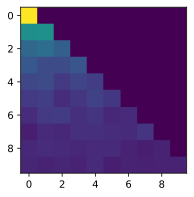

In [29]:
plt.figure(figsize=(3, 3))
plt.imshow(transformer.get_attention_maps(x, mask)[0][0].mean(dim=0).detach().numpy());

<br>

**Remark.** Batch normalization is not good for language since 
features of words tend to have a much higher variance 
(i.e. rare words are not represented well in the distribution esetimate).
The residual connection helps with gradient propagation since Transformers are designed to be very deep. LN does not diminish rank collapse as shown in the previous notebook. 
These properties are covered in the [last notebook](dl/05-training).
Note also that the MHA block is low rank as the singular value is dominated by the largest
(getting rank ~1):

In [30]:
pl.seed_everything(RANDOM_SEED)

Seed set to 42


42

In [31]:
mha = MultiheadAttention(d_model=128, num_heads=8)
x = torch.randn(1, 1024, 128)
q = mha.w_q(x)
k = mha.w_k(x)
a = mha(x, x, x)
s_q = torch.linalg.svd(q[0])[1]
s_k = torch.linalg.svd(k[0])[1]
s_a = torch.linalg.svd(a[0])[1]
s_r = torch.linalg.svd((x + a)[0])[1]

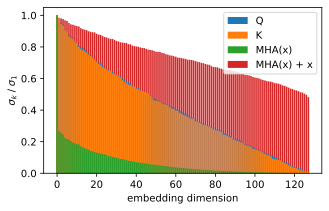

In [32]:
plt.figure(figsize=(5, 3))
plt.bar(range(128), (s_q / s_q[0]).detach().numpy(), label="Q")
plt.bar(range(128), (s_k / s_k[0]).detach().numpy(), label="K")
plt.bar(range(128), (s_a / s_a[0]).detach().numpy(), label="MHA(x)")
plt.bar(range(128), (s_r / s_r[0]).detach().numpy(), label="MHA(x) + x", zorder=-3)
plt.xlabel("embedding dimension")
plt.ylabel(f"$\sigma_k\; /\; \sigma_1$")
plt.legend();

**Note.** Recall residual connections and low rank simulates 
[large associative memory](https://en.wikipedia.org/wiki/Content-addressable_memory).

## Training: Reverse prediction

To demonstrate the Transformer model, we train it for the simple task of predicting the digits of an input sequence in reverse. For example, the goal is to predict `[3, 2, 1]` from  `[1, 2, 3]`. This is a simple enough Seq2Seq task to describe. However, [recurrent models](https://en.wikipedia.org/wiki/Recurrent_neural_network) have difficulty with this because the hidden state is unable to store long term dependencies. Transformers on the other hand support long term dependencies since embeddings at any two positions are able to communicate directly.

In [33]:
class ReverseDataset(Dataset):
    def __init__(self, n_classes, seq_len, size):
        super().__init__()
        self.n_classes = n_classes
        self.seq_len = seq_len
        self.size = size
        self.data = torch.randint(self.n_classes, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        input_data = self.data[idx]
        labels = torch.flip(input_data, dims=(-1,))
        return input_data, labels

In [34]:
from functools import partial

C = 10
T = 16
dataset = partial(ReverseDataset, C, T)
train_loader = DataLoader(dataset(50000), batch_size=32, shuffle=True, drop_last=True, pin_memory=True)
valid_loader = DataLoader(dataset(1000),  batch_size=32)
infer_loader = DataLoader(dataset(10000), batch_size=32)

Sample instance:

In [35]:
x, y = train_loader.dataset[0]
print("x:", x)
print("y:", y)

x: tensor([0, 2, 8, 3, 0, 1, 1, 1, 9, 4, 4, 8, 0, 5, 8, 5])
y: tensor([5, 8, 5, 0, 8, 4, 4, 9, 1, 1, 1, 0, 3, 8, 2, 0])


<br>

**Learning rate warm-up.** To allow the gradient estimates in adapative methods such as Adam to stabilize, we scale the learning rate with a factor $\gamma > 0.$ This also helps with fine-tuning since it allows the network to adapt slowly to new data. In particular, the **cosine warm-up schedule** is typically used where $\gamma$ grows roughly linearly starting from zero at the warm-up stage and decays smoothly as a cosine curve until goes back to zero at `max_iter` (end of training).

In [36]:
class CosineWarmupScheduler(torch.optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup, max_iter):
        self.warmup = warmup
        self.max_iter = max_iter
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(step=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, step):
        lr_factor = 0.5 * (1 + np.cos(np.pi * step / self.max_iter)) 
        lr_factor *= min(1.0, step / self.warmup)   # warm-up
        return lr_factor

# Note: for small warmup, 0.5(1.0 + cos(...)) ~ 1 at early steps, so max lr_factor ~ 1.
p = nn.Parameter(torch.empty(4,4))
optim = torch.optim.Adam([p], lr=1e-3)
cos = CosineWarmupScheduler(optim, warmup=150, max_iter=1500)
lrs = [cos.get_lr_factor(step) for step in range(1500)]

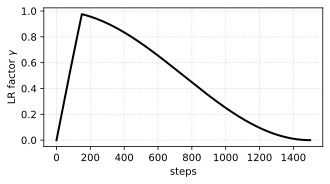

In [37]:
plt.figure(figsize=(5, 2.5))
plt.grid(linestyle="dotted", alpha=0.6)
plt.plot(lrs, linewidth=2, color="k")
plt.xlabel("steps")
plt.ylabel(f"LR factor $\gamma$");

<br>

**Transformer module.** Module for training a 
next token prediction model based on the Transformer encoder. 
In addition to the Transformer encoder, we add an embedding layer, the positional encoding, and a classification network to transform output encodings to predictions. 
The embedding layer converts inputs `(B, T)` to `(B, T, d_model)`.
The feed-forward classification network is applied to the embedding dimension, so we get output probabilities of shape `(B, T, C)`. Note that layer normalization is applied to the logits. We also configure an LR scheduler, which updates at each step. The resulting network is fairly generic for sequential classification tasks.

In [38]:
class TransformerPredictor(pl.LightningModule):
    def __init__(self, 
                 d_model: int,
                 n_heads: int, 
                 n_blocks: int,
                 n_classes: int,
                 lr: float,
                 warmup: int = None, 
                 max_iter: int = None, 
                 dropout: float = 0.0):
        
        super().__init__()
        self.save_hyperparameters()
        self.hp = self.hparams
        self._create_model()

    def _create_model(self):
        self.dropout = nn.Dropout(self.hp.dropout)
        self.embedding = nn.Embedding(self.hp.n_classes, self.hp.d_model)
        self.pos_encoding = PositionalEncoding(d_model=self.hp.d_model)
        self.transformer = TransformerEncoder(n_blocks=self.hp.n_blocks, 
                                              d_model=self.hp.d_model,
                                              ffn_width=2 * self.hp.d_model,
                                              n_heads=self.hp.n_heads,
                                              dropout=self.hp.dropout)

        self.classifier = nn.Sequential(
            nn.Linear(self.hp.d_model, self.hp.d_model),
            nn.LayerNorm(self.hp.d_model),
            nn.ReLU(inplace=True),
            nn.Dropout(self.hp.dropout),
            nn.Linear(self.hp.d_model, self.hp.n_classes),
            nn.LayerNorm(self.hp.n_classes) # also normalize logits
        )

    def forward(self, x, mask=None, add_positional_encoding=True):
        x = self.embedding(x)
        x = self.pos_encoding(x) if add_positional_encoding else x
        x = self.dropout(x)
        x = self.transformer(x, mask=mask)
        x = self.classifier(x)
        return x

    @torch.no_grad()
    def get_attention_maps(self, x, mask=None, add_positional_encoding=True):
        x = self.embedding(x)
        x = self.pos_encoding(x) if add_positional_encoding else x
        attention_maps = self.transformer.get_attention_maps(x, mask=mask)
        return attention_maps

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=self.hp.lr)
        if self.hp.warmup is not None:
            lr_scheduler = CosineWarmupScheduler(optim, warmup=self.hp.warmup, max_iter=self.hp.max_iter)
            return [optim], [{"scheduler": lr_scheduler, "interval": "step"}]
        else:
            return optim
    
    def _calculate_loss(self, batch, mode="train"):
        x, y = batch
        preds = self.forward(x, add_positional_encoding=True)
        loss = F.cross_entropy(preds.view(-1, preds.shape[-1]), y.view(-1))     # out: (B * T, C)  target: (B * T,)
        accu = (preds.argmax(dim=-1) == y).float().mean()
        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_accu", accu)
        return loss, accu

    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="valid")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="infer")

Most parameters are in the attention blocks:

In [39]:
import torchinfo

tp = TransformerPredictor(
    d_model=128, 
    n_heads=4, 
    n_blocks=2, 
    n_classes=10,
    lr=0.1, 
    warmup=200, 
    max_iter=1500, 
    dropout=0.2
)

torchinfo.summary(tp)

Layer (type:depth-idx)                        Param #
TransformerPredictor                          --
├─Dropout: 1-1                                --
├─Embedding: 1-2                              1,280
├─PositionalEncoding: 1-3                     --
├─TransformerEncoder: 1-4                     --
│    └─ModuleList: 2-1                        --
│    │    └─EncoderBlock: 3-1                 131,968
│    │    └─EncoderBlock: 3-2                 131,968
├─Sequential: 1-5                             --
│    └─Linear: 2-2                            16,512
│    └─LayerNorm: 2-3                         256
│    └─ReLU: 2-4                              --
│    └─Dropout: 2-5                           --
│    └─Linear: 2-6                            1,290
│    └─LayerNorm: 2-7                         20
Total params: 283,294
Trainable params: 283,294
Non-trainable params: 0

Trying out inference on a batch:

In [40]:
x = torch.randint(0, 10, size=(3, 8))
print("x\n", x)
print()
print("tp(x)\n", tp(x).argmax(dim=-1))

x
 tensor([[3, 7, 7, 3, 1, 2, 0, 9],
        [9, 3, 0, 3, 1, 5, 3, 7],
        [5, 0, 2, 0, 0, 5, 6, 5]])

tp(x)
 tensor([[3, 1, 3, 3, 3, 9, 9, 3],
        [3, 3, 3, 9, 9, 8, 3, 9],
        [8, 3, 0, 1, 3, 3, 3, 1]])


In [41]:
del tp

Compiling the experiment:

In [42]:
from lightning.pytorch.loggers import CSVLogger

def train_reverse(experiment="base", epochs=1, **kwargs):
    logger = CSVLogger("./logs/ReversePrediction", name=experiment)
    trainer = pl.Trainer(accelerator=str(DEVICE),
                         devices=1,
                         max_epochs=epochs,
                         gradient_clip_val=5,
                         logger=logger,
                         log_every_n_steps=1)
    
    max_iter = trainer.max_epochs * len(train_loader)
    model = TransformerPredictor(max_iter=max_iter, **kwargs)
    trainer.fit(model, train_loader, valid_loader)
    
    # Test trained model on validation and test set
    valid_result = trainer.test(model, valid_loader, verbose=False)[0]
    infer_result = trainer.test(model, infer_loader, verbose=False)[0]
    result = {"infer_accu": infer_result["infer_accu"], "valid_accu": valid_result["infer_accu"]}
    
    model = model.to(DEVICE)
    return model, result

As suggested by the paper {cite}`preln-transformer`, warm-up may not be necessary. But we do it for the sake of demonstration. Running the experiment:

In [43]:
reverse_model, reverse_result = train_reverse(d_model=32,
                                              n_heads=2,
                                              n_classes=10,
                                              n_blocks=2,
                                              dropout=0.1,
                                              epochs=3,
                                              lr=1e-3,
                                              warmup=100)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type               | Params
----------------------------------------------------
0 | dropout      | Dropout            | 0     
1 | embedding    | Embedding          | 320   
2 | pos_encoding | PositionalEncoding | 0     
3 | transformer  | TransformerEncoder | 16.8 K
4 | classifier   | Sequential         | 1.5 K 
----------------------------------------------------
18.6 K    Trainable params
0         Non-trainable params
18.6 K    Total params
0.074     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

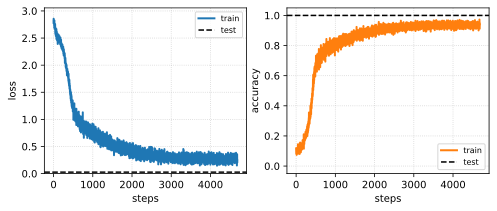

In [44]:
path = "base/version_0"
_, ax = plt.subplots(1, 2, figsize=(8, 3))
df = pd.read_csv(f"logs/ReversePrediction/{path}/metrics.csv")
train_loss = [l for l in df.train_loss.tolist() if not pd.isna(l)]
train_accu = [l for l in df.train_accu.tolist() if not pd.isna(l)]
ax[0].plot(train_loss, linewidth=2, label="train")
ax[0].axhline(df.iloc[-1]["infer_loss"], color="k", linestyle="dashed", label="test")
ax[0].set_ylabel("loss")
ax[0].set_xlabel("steps")
ax[0].set_ylim(0.0, min(max(train_loss) + 0.2, 5.0))
ax[0].grid(linestyle="dotted", alpha=0.6)
ax[0].legend(fontsize=8)

ax[1].plot(train_accu, linewidth=2, label="train", color="C1")
ax[1].axhline(df.iloc[-1]["infer_accu"], color="k", linestyle="dashed", label="test")
ax[1].set_ylabel("accuracy")
ax[1].set_xlabel("steps")
ax[1].set_ylim(-0.05, 1.05)
ax[1].grid(linestyle="dotted", alpha=0.6)
ax[1].legend(fontsize=8);

The training curves are noisy and the model underfits due to dropping out the attention weight of the correct key. Since the dataset has no contextual information, the model is unable to predict the correct token whenever the respective attention weight is dropped. Finally, we can plot the attention maps of the trained Transformer:

In [45]:
x, _ = next(iter(train_loader))
x = x[:1].to(DEVICE)    # one instance
attn_map = reverse_model.get_attention_maps(x)

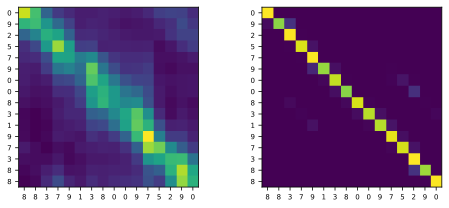

In [46]:
fig, ax = plt.subplots(1, len(attn_map), figsize=(7, 3))
for j in range(len(attn_map)):
    ax[j].set_xticks(list(range(T)))
    ax[j].set_xticklabels(x[0].tolist(), fontsize=7)
    ax[j].set_yticks(list(range(T)))
    ax[j].set_yticklabels(x[0].tolist(), fontsize=7)
    ax[j].imshow(attn_map[j][0].mean(dim=0).detach().cpu().numpy(), origin="lower")
    
fig.tight_layout()

The model has learned to attend to the token at the reversed index, as intended. However, it also gives some attention to other tokens, mostly near the reversed index. Attention to farther tokens is due to dropout, while attention to nearby tokens is from the similarity in positional encoding of nearby indices. Note that the first encoder block has the positionally encoded embeddings as inputs, hence suffers more from noise.

---

■